In [140]:
%config InlineBackend.figure_formats = ['retina']
%matplotlib inline
import pandas as pd
import uproot
import awkward
import matplotlib.pyplot as plt
import numpy as np
import math
import numba
from matplotlib.colors import LogNorm
import uproot_methods
import glob
from tqdm.auto import tqdm

from utils import set_plotting_style, numba_histogram, numba_histogram2d, make_profile

In [141]:
set_plotting_style()

In [168]:
%%time
t = uproot.open("/hadoop/cms/store/user/namin/DisplacedMuons/babies/baby_HToZZTo2Mu2X_ctau5mm_skim2mu.root")["Events"]
cache = uproot.ArrayCache("16GB")
readkw = dict(cache=cache,entrystop=10000000)

CPU times: user 81 ms, sys: 11 ms, total: 92 ms
Wall time: 201 ms


In [169]:
tlead = awkward.Table({k.split("_",1)[1]:v for k,v in t.arrays("LeadingPair_*",outputtype=dict,namedecode="ascii").items()})
tdv = awkward.Table({k.split("_",1)[1]:v for k,v in t.arrays("DV_*",outputtype=dict,namedecode="ascii").items()})
tpv = awkward.Table({k.split("_",1)[1]:v for k,v in t.arrays("PVM_*",outputtype=dict,namedecode="ascii").items()})
tmu = awkward.Table({k.split("_",1)[1]:v for k,v in t.arrays("Muon_*",outputtype=dict,namedecode="ascii").items()})
tgen = awkward.Table({k.split("_",1)[1]:v for k,v in t.arrays("GenMuon_*",outputtype=dict,namedecode="ascii").items()})

tgen["rho"] = np.hypot(tgen.vx,tgen.vy)
tdv["rho"] = np.hypot(tdv.x,tdv.y)
tgen["p4"] = uproot_methods.TLorentzVectorArray.from_ptetaphim(tgen.pt,tgen.eta,tgen.phi,tgen.m)

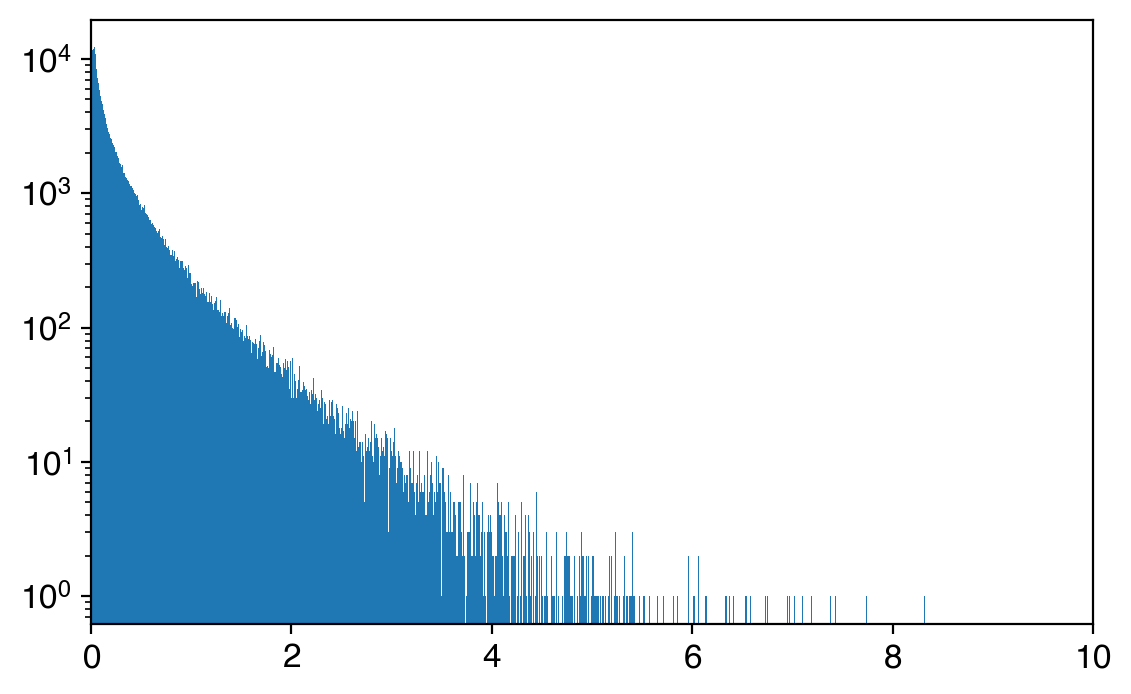

In [170]:
fig,ax = plt.subplots()
_ = ax.hist(np.abs(tmu.dxy.flatten()),bins=np.linspace(0,10,1000));
ax.set_yscale("log")

CPU times: user 43 ms, sys: 0 ns, total: 43 ms
Wall time: 42.1 ms


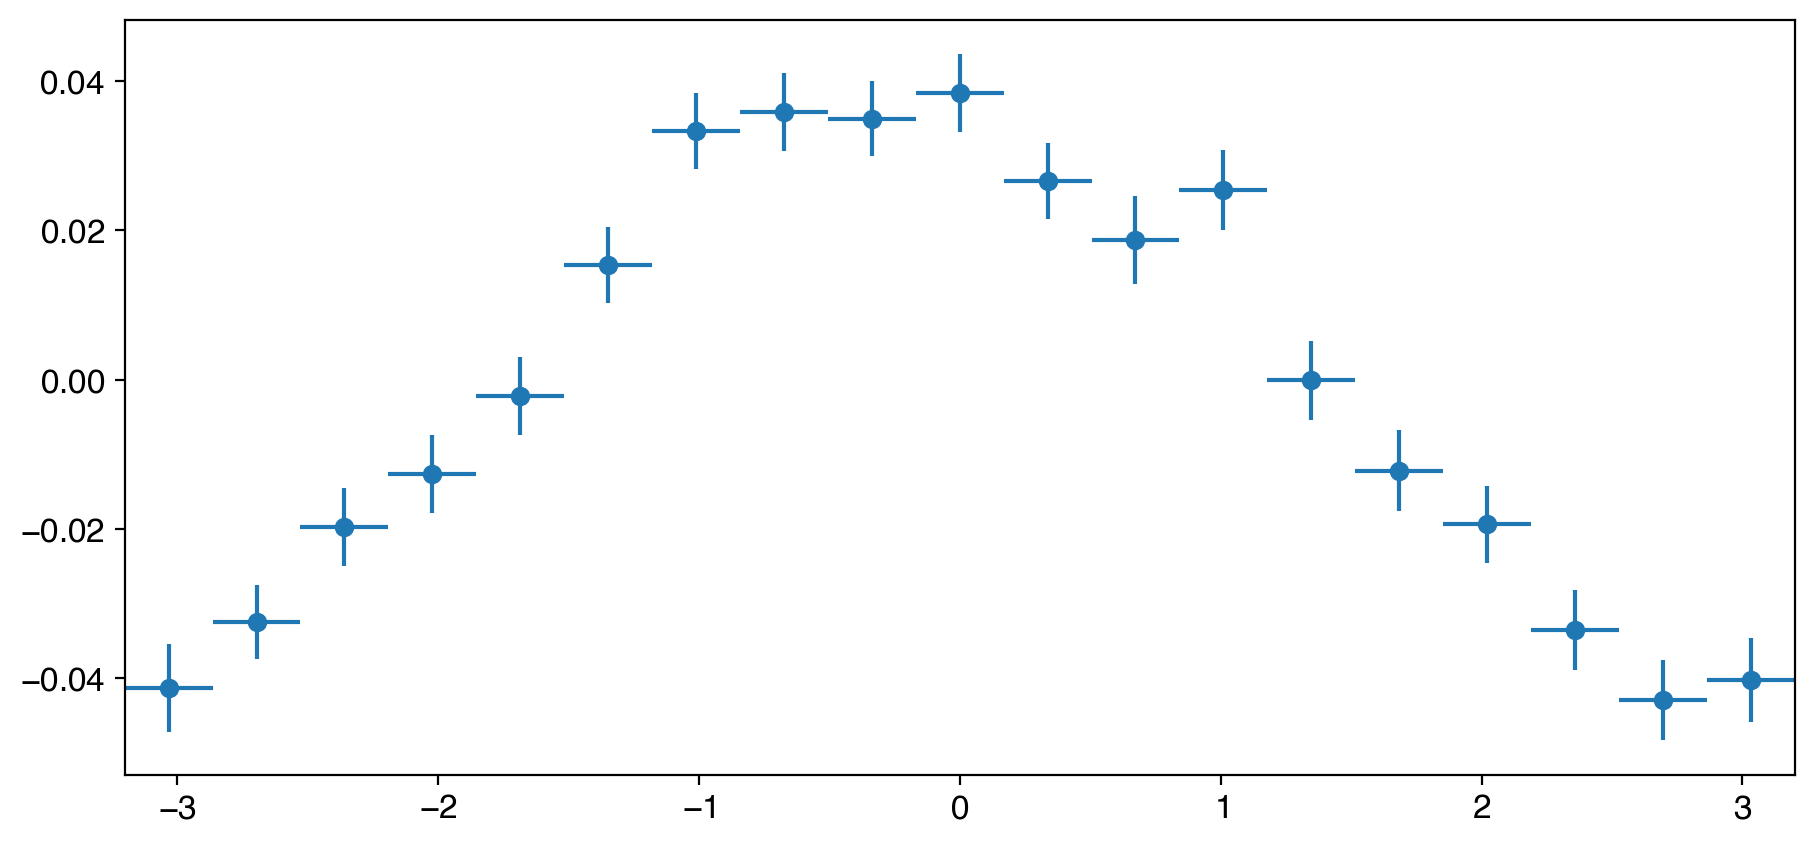

In [171]:
%%time
edges = np.linspace(-3.2,3.2,20)
y,yerr = make_profile(tobin=tmu.phi.flatten(),toreduce=tmu.dxy.flatten(),edges=edges)
# from scipy.stats import binned_statistic
# # edges = np.logspace(0.,1.5,200)
# edges = np.linspace(0.0,20.,200)
# yvals = binned_statistic(np.clip(rho,edges[0],edges[-1]), costheta, 'mean', bins=edges).statistic
# yerr = binned_statistic(np.clip(rho,edges[0],edges[-1]), costheta, 'std', bins=edges).statistic/(binned_statistic(rho, costheta, 'count', bins=edges).statistic**0.5)
fig,ax = plt.subplots(figsize=(10,5))
centers = 0.5*(edges[1:]+edges[:-1])
xerr = (edges[1:]-edges[:-1])/2
_ = ax.errorbar(centers,y,yerr=yerr,xerr=xerr,fmt='o')
# ax.vlines([3.0,6.8,10.9,16.0],0,1.0,transform=ax.get_xaxis_transform(), colors='k')
# ax.set_xscale("log")
# ax.set_ylabel(r"Mean cos$\theta$")
# ax.set_xlabel("DV rho")

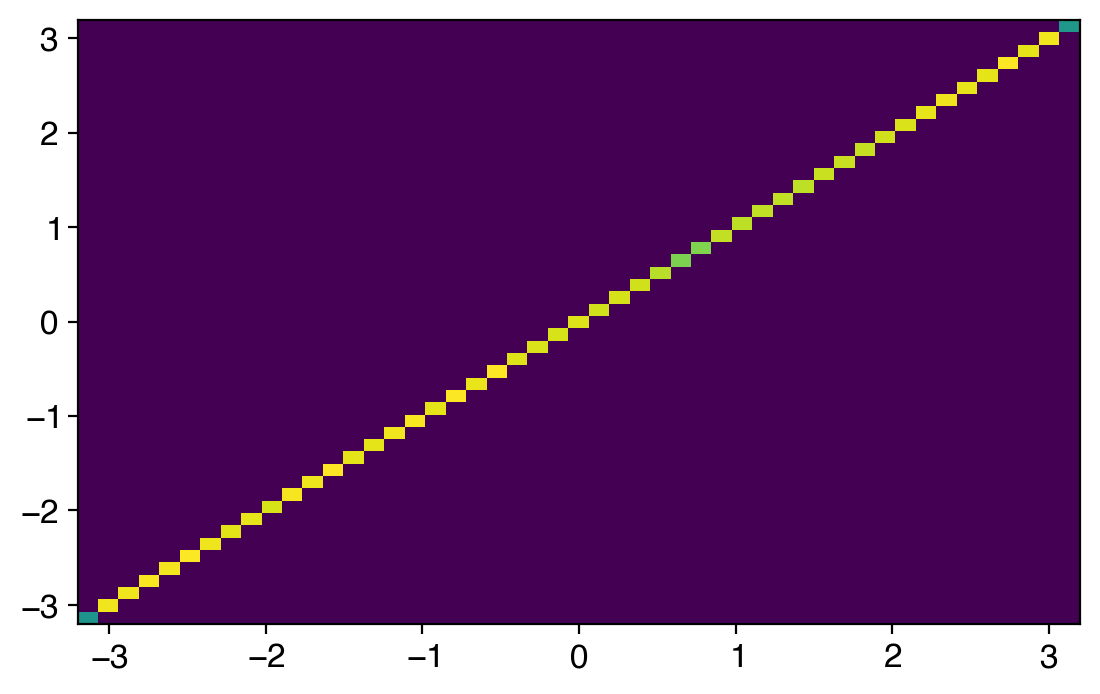

In [172]:
# tmu.phi.flatten(),toreduce=tmu.dxy.flatten(),edges=edges)
fig,ax = plt.subplots()
bins = [np.linspace(-3.2,3.2,50),np.linspace(-3.2,3.2,50)]
ax.hist2d(tmu.trk_phi.flatten(),tmu.phi.flatten(),bins=bins);

In [173]:
# https://github.com/cms-sw/cmssw/blob/master/DataFormats/TrackReco/interface/TrackBase.h#L24
# https://github.com/cms-sw/cmssw/blob/master/DataFormats/TrackReco/interface/TrackBase.h#L647
def calc_dxy(x,y,phi):
    return -x*np.sin(phi) + y*np.cos(phi)
mydxy = calc_dxy(tdv.x[:,0],tdv.y[:,0],tmu.phi)

In [174]:
tmu.dxy

<JaggedArray [[0.02479314 0.17786498] [0.058187086 -0.21494226] [-0.3931198 0.5270012] ... [0.06151726 -0.13266003] [-0.015178304 0.045547277] [0.7707246 -1.5851322]] at 0x7f9f2b456dd8>

In [175]:
print(tdv.y.shape)
print(tmu.phi.shape)

(99887,)
(99887,)


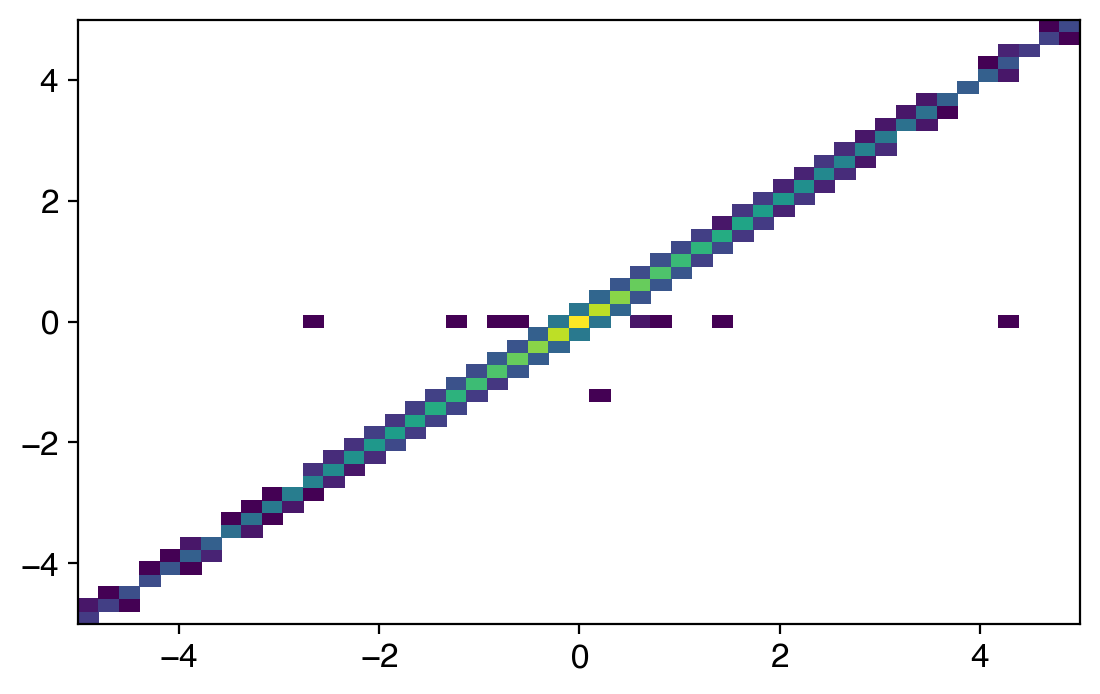

In [176]:
fig,ax = plt.subplots()
bins = [np.linspace(-5,5,50),np.linspace(-5,5,50)]
# ax.hist2d(mydxy.flatten(),tmu.dxy.flatten(),bins=bins,norm=LogNorm());
# sel = (tdv.x.counts >= 2) & (tmu.dxy.counts >= 3)
sel = (tdv.x.counts == 1) & (tmu.dxy.counts == 2)
ax.hist2d(mydxy[sel].flatten(),tmu.dxy[sel].flatten(),bins=bins,norm=LogNorm());

In [177]:
# (mydxy[sel].flatten()-tmu.dxy[sel].flatten()).mean()
(mydxy[sel].flatten()-tmu.dxy[sel].flatten()).std()

0.013739595

In [178]:
# Events->Scan("recoBeamSpot_offlineBeamSpot__RECO.obj.x0()") in miniaod (and y0)
# https://github.com/cms-sw/cmssw/blob/master/DataFormats/BeamSpot/interface/BeamSpot.h
# for 2018 MC (gtag of 102X_upgrade2018_realistic_v11 according to edmProvDump)
bsx = 0.0107796
bsy = 0.041893
bsz = 0.0248755

In [179]:
print(tpv.x[:,0].mean())
print(tpv.y[:,0].mean())

print(tpv.x[:,0].mean()-bsx)
print(tpv.y[:,0].mean()-bsy)

0.010777747
0.04189386
-1.852741456032092e-06
8.584625720980954e-07


CPU times: user 147 ms, sys: 1 ms, total: 148 ms
Wall time: 145 ms


Text(0, 0.5, 'mean dxy')

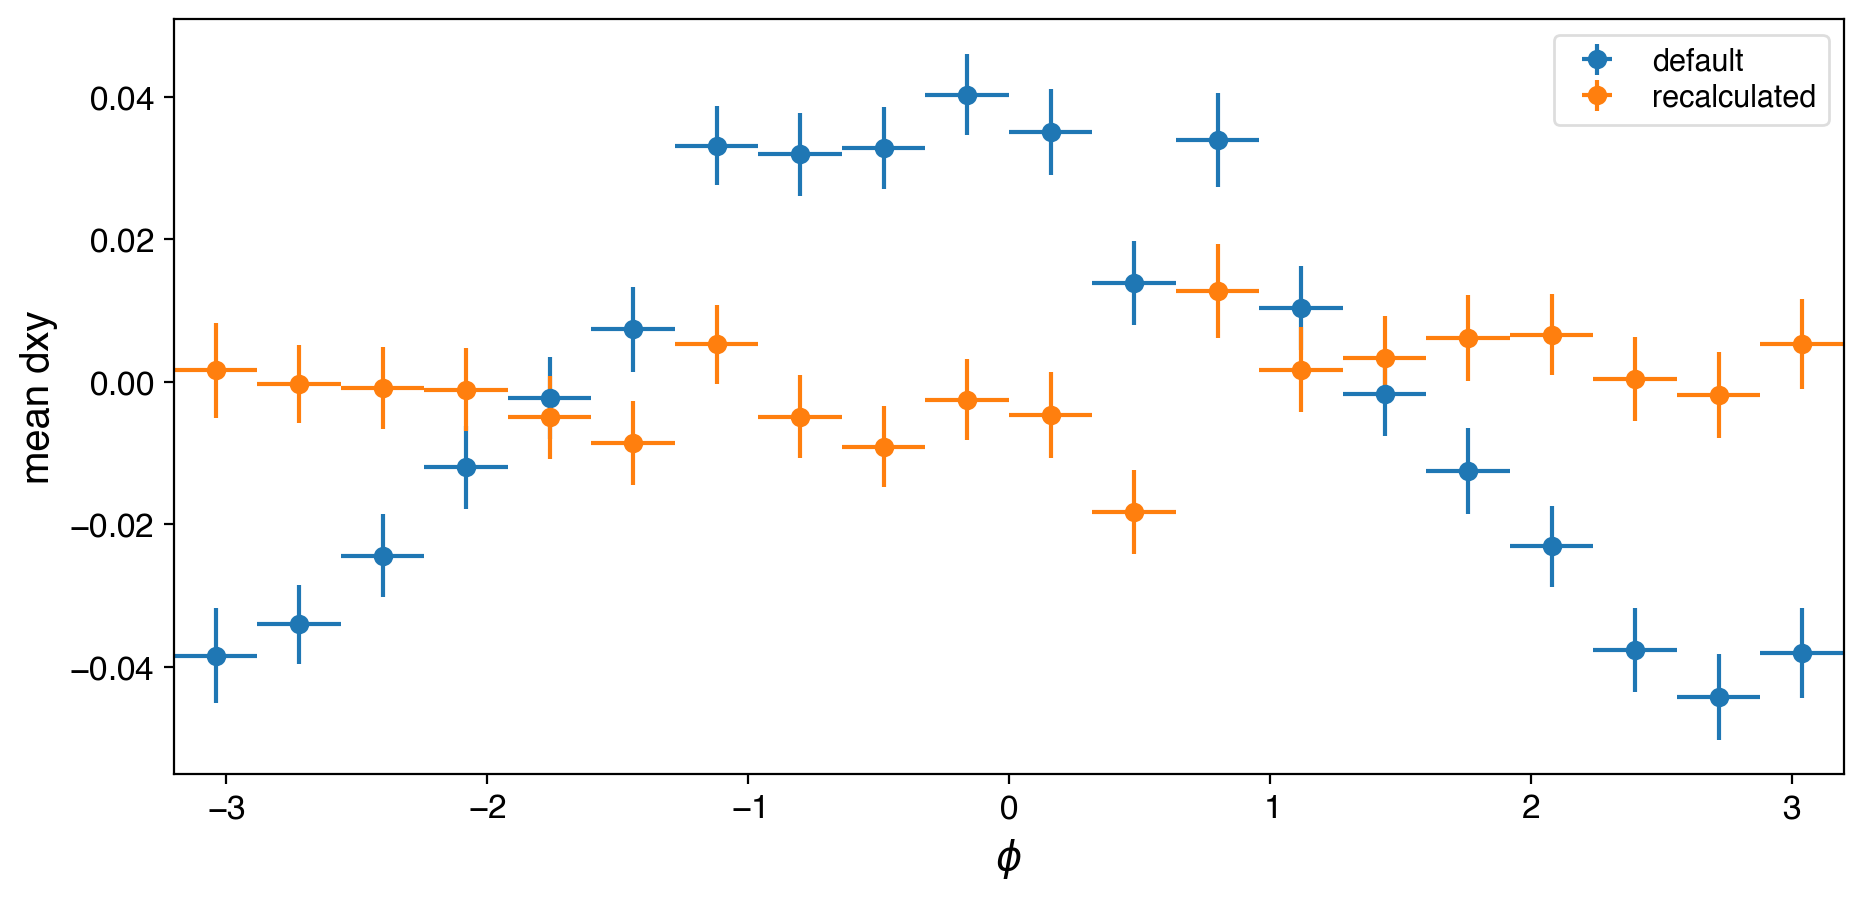

In [180]:

%%time
edges = np.linspace(-3.2,3.2,21)
sel = (tdv.x.counts == 1) & (tmu.dxy.counts == 2)

fig,ax = plt.subplots(figsize=(10,5))
centers = 0.5*(edges[1:]+edges[:-1])
xerr = (edges[1:]-edges[:-1])/2
y,yerr = make_profile(tobin=tmu.phi[sel].flatten(),toreduce=tmu.dxy[sel].flatten(),edges=edges)
_ = ax.errorbar(centers,y,yerr=yerr,xerr=xerr,fmt='o',label="default")

# mydxy = calc_dxy(tdv.x[:,0]-tpv.x.flatten().mean(),tdv.y[:,0]-tpv.y.flatten().mean(),tmu.phi)
# y,yerr = make_profile(tobin=tmu.phi[sel].flatten(),toreduce=mydxy[sel].flatten(),edges=edges)
# _ = ax.errorbar(centers,y,yerr=yerr,xerr=xerr,fmt='o',label="mine3")

# mydxy = calc_dxy(tdv.x[:,0]-tpv.x[:,0],tdv.y[:,0]-tpv.y[:,0],tmu.phi)
# y,yerr = make_profile(tobin=tmu.phi[sel].flatten(),toreduce=mydxy[sel].flatten(),edges=edges)
# _ = ax.errorbar(centers,y,yerr=yerr,xerr=xerr,fmt='o',label="mine2")

mydxy = calc_dxy(tdv.x[:,0]-bsx,tdv.y[:,0]-bsy,tmu.phi)
y,yerr = make_profile(tobin=tmu.phi[sel].flatten(),toreduce=mydxy[sel].flatten(),edges=edges)
_ = ax.errorbar(centers,y,yerr=yerr,xerr=xerr,fmt='o',label="recalculated")

ax.legend()
ax.set_xlabel(r"$\phi$")
ax.set_ylabel(r"mean dxy")

In [16]:
# dfbs = pd.concat(map(pd.read_csv,tqdm(glob.glob("/home/users/namin/2019/scouting/repo/beamspot/outputs/*.csv"))))
# dfbs

In [17]:
# for i in range(1,15):
#     t = uproot.open("/hadoop/cms/store/user/namin/ProjectMetis/ScoutingCaloMuon_Run2018C-v1_RAW_v3/output_{}.root".format(i))["Events"]
#     run = t["run"].array(**readkw)
#     lumi = t["luminosityBlock"].array(**readkw)
#     df = pd.DataFrame(dict(run=run,lumi=lumi))
#     before = df.shape[0]
#     df = df.merge(dfbs,how="left",on=["run","lumi"])
#     df = df.dropna()
#     after = df.shape[0]
#     print(i,before,after,before==after)

In [18]:
# print(
#     dfbs.x.mean(),
#     dfbs.y.mean(),
#     dfbs.x.std()*1e4,
#     dfbs.y.std()*1e4,
# )
# fig, ax = plt.subplots()
# dfbs.plot.scatter(x="x",y="y",s=0.05,ax=ax)
# ax.set_ylim([-0.070,-0.060])

In [19]:

# t = uproot.open("/hadoop/cms/store/user/namin/ProjectMetis/ScoutingCaloMuon_Run2018C-v1_RAW_v3/output_1.root")["Events"]
# t = uproot.open("/hadoop/cms/store/user/namin/ProjectMetis/ScoutingCaloMuon_Run2018C-v1_RAW_v3/output_2.root")["Events"]

In [20]:
# t.array("PVM_x")

In [ ]:
# tdv[:,0]

In [22]:
# %%time
# run = t["run"].array(**readkw)
# lumi = t["luminosityBlock"].array(**readkw)

In [23]:
# %%time
# df = pd.DataFrame(dict(run=run,lumi=lumi))
# df

In [24]:
# df = df.merge(dfbs,how="left",on=["run","lumi"])

In [26]:
# # _ = plt.hist2d(df.x,df.y,bins=[100,100],norm=LogNorm());
# xm = df.x.mean()
# xs = df.x.std()
# ym = df.y.mean()
# ys = df.y.std()
# # _ = plt.hist2d(df.x,df.y,bins=[np.linspace(0.095,0.096,100),np.linspace(-0.08,-0.05,100)],norm=LogNorm());
# _ = plt.hist2d(df.x,df.y,bins=[np.linspace(xm-5*xs,xm+5*xs,100),np.linspace(ym-0.5*ys,ym+0.5*ys,100)],norm=LogNorm());

In [ ]:

# def calc_dxy(x,y,phi):
#     return -x*np.sin(phi) + y*np.cos(phi)
# mydxy = calc_dxy(tdv.x[:,0],tdv.y[:,0],tmu.phi)

In [31]:
tmu

<Table [<Row 0> <Row 1> <Row 2> ... <Row 99884> <Row 99885> <Row 99886>] at 0x7f9f2e7822e8>

In [36]:
(tmu.phi-tmu.trk_phi).max().max()

0.0

In [45]:
# tmu.pt.counts.max()
tdv.x.counts.max()

6

In [47]:
sel = (tdv.x.counts == 1) & (tmu.dxy.counts == 2)
tmu.dxy[sel][:,0]

array([ 0.02479314,  0.05818709, -0.3931198 , ...,  0.06151726,
       -0.0151783 ,  0.7707246 ], dtype=float32)

In [55]:

mydxy = calc_dxy(tdv.x[sel][:,0],tdv.y[sel][:,0],tmu.phi[sel])
# mydxy = calc_dxy(tdv.x[sel][:,0]-bsx,tdv.y[sel][:,0]-bsy,tmu.phi[sel])

In [56]:
mydxy

<JaggedArray [[0.025108906 0.1768195] [0.058699653 -0.21466295] [-0.39302 0.5271417] ... [0.06145212 -0.13261227] [-0.01476261 0.046251483] [0.7728217 -1.5884538]] at 0x7f9f2b7bac88>

In [57]:
tdv.x[sel]

<JaggedArray [[0.29955083] [-0.25448254] [0.54308885] ... [-0.07717028] [0.11293823] [-0.23754849]] at 0x7f9f2bd209e8>

In [59]:
dxy = tmu.dxy[sel]
phi = tmu.phi[sel]
# dxy / (1 + np.tan(phi)**2. - 2*np.sin(phi)**2)**0.5
dxy*np.cos(phi)

<JaggedArray [[0.024785805 0.15440622] [-0.020784615 -0.01674843] [-0.24314362 0.18685934] ... [-0.036851645 -0.03781428] [-0.009965438 -0.02222224] [0.10824457 0.7445946]] at 0x7f9f2b87f0b8>

In [61]:
tdv.x[sel]

<JaggedArray [[0.29955083] [-0.25448254] [0.54308885] ... [-0.07717028] [0.11293823] [-0.23754849]] at 0x7f9f2bd20a90>

In [99]:
sel2 = (tdv.x.counts == 2) & (tmu.dxy.counts == 2)

In [100]:
vx = tdv.x[sel2]
vy = tdv.y[sel2]
dxy = tmu.dxy[sel2]
phi = tmu.phi[sel2]

In [101]:
dxy

<JaggedArray [[-0.077709325 0.043714855] [-0.4281664 -0.049840983] [-0.044846583 0.036686584]] at 0x7f9f2b8ee518>

In [114]:
dv0 = (-vx[:,0]*np.sin(phi)+vy[:,0]*np.cos(phi))-dxy
dv1 = (-vx[:,1]*np.sin(phi)+vy[:,1]*np.cos(phi))-dxy
issecond = np.abs(dv0) > np.abs(dv1)
issecond*1

<JaggedArray [[0 1] [0 1] [1 1]] at 0x7f9f2b873d68>

In [103]:
tmu.vtxIndx1[sel2]

<JaggedArray [[0 1] [0 1] [0 0]] at 0x7f9f2b855978>

In [115]:
vx

<JaggedArray [[-0.13084592 -0.03697354] [0.6922746 0.05570116] [0.02682409 -0.05597374]] at 0x7f9f2b7dab70>

In [116]:
vy

<JaggedArray [[0.28549686 0.079672396] [-0.9340443 0.02710613] [0.037892435 0.15947126]] at 0x7f9f2bcb51d0>

In [117]:
dxy

<JaggedArray [[-0.077709325 0.043714855] [-0.4281664 -0.049840983] [-0.044846583 0.036686584]] at 0x7f9f2b8ee518>

In [119]:
phi

<JaggedArray [[2.2466373 -0.48513827] [-0.551878 2.5895774] [2.1761289 -1.0231277]] at 0x7f9f2b873a58>

-0.05453713 -0.11380710601806641
-0.042971574 0.10413964986801148


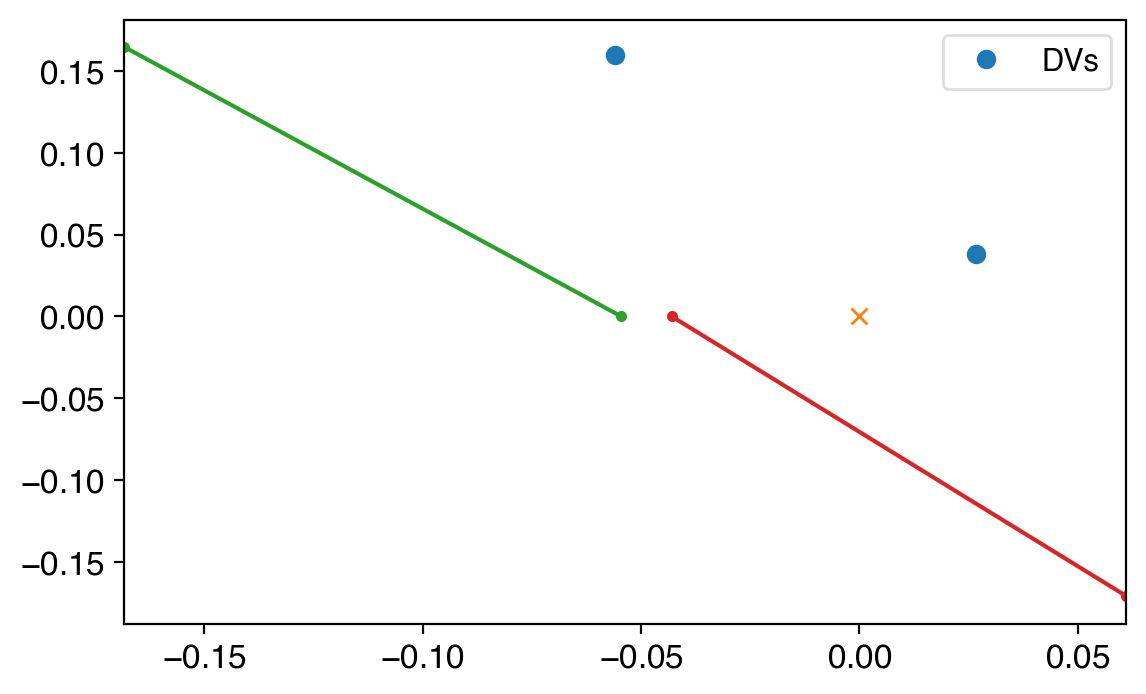

In [138]:
vxs = vx[-1]
vys = vy[-1]
phis = phi[-1]
dxys = dxy[-1]

plt.plot(vxs,vys,marker="o",linestyle="",label="DVs")
plt.plot(0,0,marker="x")
x0s = dxys/np.sin(phis)
y0s = x0s*0
delta = 0.2
for imu in range(len(phis)):
    plt.plot(
        [x0s[imu], x0s[imu]+delta*np.cos(phis[imu])],
        [y0s[imu], y0s[imu]+delta*np.sin(phis[imu])],
        marker="."
    )
    print(x0s[imu], delta*np.cos(phis[imu]))
plt.legend()